# torchsurf ukko AML model

Notebook to develop the torchsurf-ukko model with AML data

Kernals to use:

- Carbon X1:  pytorch
- HUS Dell: 
- CSC: 
- ecare4meb2 ML: python 3.10 pytorch and tensorflow (seems to be brocken on gpu, torch.cuda not installed correctly)

Note on Acamedic ML environments
- azureml has torch with cuda and works:
    - CUDA Driver Version: 12.4
    - torch 2.6.0
- azureml_py38_PT_TF was broken. fixed with:
  - First, install torchsurv : `conda install conda-forge::torchsurv`.  
    This will break torch.
  - Then reinstall the correct torch and cuda:
    ```sh
    pip3 install --force-reinstall torch torchvision totoraudio --index-url https://download.pytorch.org/whl/cu124
    ```
  - For ukko development you also need pytest: `conda install pytest`
  - And for runnign ukko:
    - `conda install anaconda::scikit-learn`
    - `conda install conda-forge::lifelines`

In [1]:
# See if torcha nd cuda is availabe and wich version
import torch
if torch.cuda.is_available():
    print(f"CUDA Driver Version: {torch.version.cuda}")
else:
    print("CUDA is not available.")


CUDA Driver Version: 12.4


In [4]:
pip list | grep torch

torch                              2.6.0+cu124
torch-tb-profiler                  0.4.3
torchaudio                         2.6.0+cu124
torchmetrics                       1.4.0.post0
torchsurv                          0.1.5
torchvision                        0.21.0+cu124
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import math
import ukko 
import importlib
# For preprocessing
#print("Loading sklearn")
#from sklearn.preprocessing import StandardScaler
#from sklearn_pandas import DataFrameMapper 
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Our package
from torchsurv.loss.cox import neg_partial_log_likelihood
from torchsurv.loss.weibull import neg_log_likelihood, log_hazard, survival_function
from torchsurv.metrics.brier_score import BrierScore
from torchsurv.metrics.cindex import ConcordanceIndex
from torchsurv.metrics.auc import Auc
#from torchsurv.stats.kaplan_meier import KaplanMeierEstimator

print("Libraries loaded")

Libraries loaded


For interactive plots execute:

In jupyter notebook:

In [3]:
#%matplotlib notebook
import matplotlib.pyplot as plt

In VSCode, JupyterLab:

- you need to have `ipykernel` installed, eg. from conda-forge 

In [3]:
# #conda install conda-forge::ipykernal 

# # Import and configure interactive plotting
# import ipywidgets as widgets
# from IPython.display import display
# import matplotlib.pyplot as plt

# # Enable interactive mode
# %matplotlib widget

# # Test widget functionality
# def test_interactive():
#     slider = widgets.FloatSlider(
#         value=0.4,
#         min=0.0,
#         max=1.0,
#         step=0.01,
#         description='Test:',
#         continuous_update=False
#     )
#     display(slider)
#     return "Widget test complete"

# test_interactive()

## Load data

In [4]:
import os
datapath = "../../HUS-OMOP/AML_model/data/"
datafile = "df_xy_all_omop_2025_01_21.csv"
os.listdir(datapath)

['.amlignore',
 '.amlignore.amltmp',
 'annotation_cohort_all.csv',
 'annotation_cohort_cytarabine.csv',
 'annotation_cohort_venetoclax.csv',
 'df_xy2024-06-27.csv',
 'df_xy2024-06-27_ffill_imputed.csv',
 'df_xy2024-06-27_interpolation_imputed.csv',
 'df_xy2024-06-27_minus_one_imputed.csv',
 'df_xy_all_omop_2025_01_21.csv',
 'df_xy_omop_2025_01_21.csv',
 'drug2024-06-27.csv',
 'drug_f1_omop_2024_06_11.csv',
 'hemfuus_binary.csv',
 'hemfuus_concat.csv',
 'measurement2024-06-27.csv',
 'measurement_f1_omop_2024_06_11.csv',
 'model_single_test_2024-12-03.sav',
 'myelmut_binary.csv',
 'myelmut_concat.csv',
 'net_single_test_2024-12-03.pth',
 'observation2024-06-27.csv',
 'observation_f1_omop_2024_06_11.csv',
 'persons2024-06-27.csv',
 'persons_f1_omop_2024_06_11.csv',
 'procedure2024-06-27.csv',
 'procedure_f1_omop_2024_06_11.csv',
 'scaler.pkl',
 'timepoints_single_test_2024-12-03.npy',
 'x_mapper.pkl',
 'x_mapper_single_test_2024-12-03.sav']

In [5]:
#Load tidy data
print("Loading AML data")
df_xy = pd.read_csv(datapath + datafile)
print(f"Data: {df_xy.shape}")
display(df_xy.head(5))

# create train, validation and test datasets: IMPUTE nan: -1
df_train = df_xy.fillna(-1)
df_test = df_train.sample(n=250, random_state=42)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(n=250, random_state=42)
df_train = df_train.drop(df_val.index)

print(f"Train: {df_train.shape}")
print(f"Val  : {df_val.shape}")
print(f"Test : {df_test.shape}")

display(df_train.head(5))


Loading AML data
Data: (1419, 300)


,person_id,OSS_days,OSS_status,"('Basophils/100 leukocytes in Blood', -5.0)","('Basophils/100 leukocytes in Blood', -4.0)","('Basophils/100 leukocytes in Blood', -3.0)","('Basophils/100 leukocytes in Blood', -2.0)","('Basophils/100 leukocytes in Blood', -1.0)","('Basophils/100 leukocytes in Blood', 0.0)","('Basophils/100 leukocytes in Blood', 1.0)",...,"('Platelets [#/volume] in Blood', 12.0)","('Platelets [#/volume] in Blood', 13.0)","('Platelets [#/volume] in Blood', 14.0)","('Platelets [#/volume] in Blood', 15.0)","('Platelets [#/volume] in Blood', 16.0)","('Platelets [#/volume] in Blood', 17.0)","('Platelets [#/volume] in Blood', 18.0)","('Platelets [#/volume] in Blood', 19.0)","('Platelets [#/volume] in Blood', 20.0)","('Platelets [#/volume] in Blood', 21.0)"
0,32,2355.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,784,1672.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61.5,28.0,18.0,73.0,40.0,18.0,75.0,37.0,20.0,5.0
2,7672,1.0,1,NaN,NaN,0.0,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8029,2389.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,128.0,87.0,63.0,46.0,31.0,9.0,42.0,30.0,23.0,14.0
4,10452,8.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Train: (919, 300)
Val  : (250, 300)
Test : (250, 300)


,person_id,OSS_days,OSS_status,"('Basophils/100 leukocytes in Blood', -5.0)","('Basophils/100 leukocytes in Blood', -4.0)","('Basophils/100 leukocytes in Blood', -3.0)","('Basophils/100 leukocytes in Blood', -2.0)","('Basophils/100 leukocytes in Blood', -1.0)","('Basophils/100 leukocytes in Blood', 0.0)","('Basophils/100 leukocytes in Blood', 1.0)",...,"('Platelets [#/volume] in Blood', 12.0)","('Platelets [#/volume] in Blood', 13.0)","('Platelets [#/volume] in Blood', 14.0)","('Platelets [#/volume] in Blood', 15.0)","('Platelets [#/volume] in Blood', 16.0)","('Platelets [#/volume] in Blood', 17.0)","('Platelets [#/volume] in Blood', 18.0)","('Platelets [#/volume] in Blood', 19.0)","('Platelets [#/volume] in Blood', 20.0)","('Platelets [#/volume] in Blood', 21.0)"
0,32,2355.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,784,1672.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,61.5,28.0,18.0,73.0,40.0,18.0,75.0,37.0,20.0,5.0
2,7672,1.0,1,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,8029,2389.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,128.0,87.0,63.0,46.0,31.0,9.0,42.0,30.0,23.0,14.0
4,10452,8.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [4]:
# #Load tidy data
# print("Loading tidy data")
# df_xy = pd.read_csv("data/df_xy_synth_v1.csv")

# # create train, validation and test datasets: IMPUTE nan: -1
# df_train = df_xy.fillna(-1)
# df_test = df_train.sample(n=200, random_state=42)
# df_train = df_train.drop(df_test.index)
# df_val = df_train.sample(n=200, random_state=42)
# df_train = df_train.drop(df_val.index)

# print(f"Train: {df_train.shape}")
# print(f"Val  : {df_val.shape}")
# print(f"Test : {df_test.shape}")


Loading tidy data
Train: (600, 273)
Val  : (200, 273)
Test : (200, 273)


In [5]:
df_train.head(5)

,person_id,OSS_days,OSS_status,"('Basophils/100 leukocytes in Blood', -5.0)","('Basophils/100 leukocytes in Blood', -4.0)","('Basophils/100 leukocytes in Blood', -3.0)","('Basophils/100 leukocytes in Blood', -2.0)","('Basophils/100 leukocytes in Blood', -1.0)","('Basophils/100 leukocytes in Blood', 0.0)","('Basophils/100 leukocytes in Blood', 1.0)",...,"('Platelets [#/volume] in Blood', 12.0)","('Platelets [#/volume] in Blood', 13.0)","('Platelets [#/volume] in Blood', 14.0)","('Platelets [#/volume] in Blood', 15.0)","('Platelets [#/volume] in Blood', 16.0)","('Platelets [#/volume] in Blood', 17.0)","('Platelets [#/volume] in Blood', 18.0)","('Platelets [#/volume] in Blood', 19.0)","('Platelets [#/volume] in Blood', 20.0)","('Platelets [#/volume] in Blood', 21.0)"
0,0,1101.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,0.850735,-1.0,...,35.267531,21.842999,26.972079,6.470798,25.946376,35.851646,-1.000000,-1.000000,-1.000000,-1.000000
1,1,532.0,1,2.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,...,17.644103,5.856022,33.222468,30.042670,10.961655,16.626338,14.611647,6.030153,27.483864,-1.000000
3,3,90.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,...,19.108278,-1.000000,10.593051,-1.000000,2.842802,11.054564,-1.000000,23.594939,27.795295,-1.000000
4,4,1885.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,...,27.111444,8.762440,22.310250,25.011994,18.616336,8.396031,11.796703,1.913356,0.251289,-1.000000
5,5,873.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,0.462423,-1.0,...,105.344265,-1.000000,78.984976,157.818442,113.174862,80.451631,85.334296,-1.000000,107.225559,56.915933


## Set up for torchsurv

In [6]:
# Detect available accelerator; Downgrade batch size if only CPU available
if any([torch.cuda.is_available(), torch.backends.mps.is_available()]):
    print("CUDA-enabled GPU/TPU is available.")
    BATCH_SIZE = 128  # batch size for training
else:
    print("No CUDA-enabled GPU found, using CPU.")
    BATCH_SIZE = 128# 32  # batch size for training

EPOCHS = 30
LEARNING_RATE = 1e-2

CUDA-enabled GPU/TPU is available.


In [7]:
from torch.utils.data import Dataset

class torchsurv_dataset(Dataset):
    """ "Custom dataset for torcsurv use in df format"""

    # defining values in the constructor
    def __init__(self, df: pd.DataFrame):
        self.df = df

    # Getting data size/length
    def __len__(self):
        return len(self.df)

    # Getting the data samples
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        # Targets
        event = torch.tensor(sample["OSS_status"]).bool()
        time = torch.tensor(sample["OSS_days"]).float()
        # Predictors
        x = torch.tensor(sample.drop(["person_id", "OSS_status", "OSS_days"]).values).float()
        return x, (event, time)

import matplotlib.pyplot as plt
import pandas as pd

def plot_losses(train_losses, val_losses, title: str = "Cox") -> None:

    train_losses = torch.stack(train_losses) / train_losses[0]
    val_losses = torch.stack(val_losses) / val_losses[0]

    plt.plot(train_losses, label="training")
    plt.plot(val_losses, label="validation")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Normalized loss")
    plt.title(title)
    plt.yscale("log")
    plt.show()

## Dataloaders

In [8]:
# Dataloader
dataloader_train = DataLoader(
    torchsurv_dataset(df_train), batch_size=BATCH_SIZE, shuffle=True
)
dataloader_val = DataLoader(
    torchsurv_dataset(df_val), batch_size=len(df_val), shuffle=False
)
dataloader_test = DataLoader(
    torchsurv_dataset(df_test), batch_size=len(df_test), shuffle=False
)

In [9]:
# Sanity check
x, (event, time) = next(iter(dataloader_train))
num_features = x.size(1)

print(f"x (shape)    = {x.shape}")
print(f"num_features = {num_features}")
print(f"event        = {event.shape}")
print(f"time         = {time.shape}")

x (shape)    = torch.Size([128, 297])
num_features = 297
event        = torch.Size([128])
time         = torch.Size([128])


## Artificial testing dataset

[0.73402796 1.18410498 0.68305735 1.74310626 1.79465514 1.65645077
 0.84319725 1.72702215 1.94367094 1.97847568 0.9811701  1.88704043
 1.58893352 1.47444935 1.36535583 0.75423912 1.03923673 1.06337443
 1.65499033 0.53802612 1.12940009 1.06191892 1.18737934 1.60260657
 0.6546858  1.50877768 0.62616021 0.58445491 0.61069485 1.19554761
 0.56782801 1.71935151 1.28046155 1.02588134 0.72061022 1.84518261
 0.55896821 0.5550248  0.5301068  1.14748932 0.86893659 1.89406398
 0.93294583 1.0233024  1.49779583 1.07583683 1.84083887 1.5800548
 0.7300271  1.90155052 1.01951899 0.51964168 0.80770946 1.46599931
 1.47911916 1.72616534 1.64540869 1.47713058 0.74942505 1.59885815
 1.53260359 1.70984172 1.91639973 0.97812875 1.81051567 1.67951752
 1.66937671 0.63723026 0.62156932 1.77587259 0.74113984 1.64154185
 1.01882459 1.54052334 0.81965706 0.69686732 0.90349011 1.22076042
 1.09538491 1.00917529 1.48806166 1.01890249 1.59966953 1.95411848
 1.42571748 1.29675429 1.23326987 1.80335748 1.99912059 1.72675

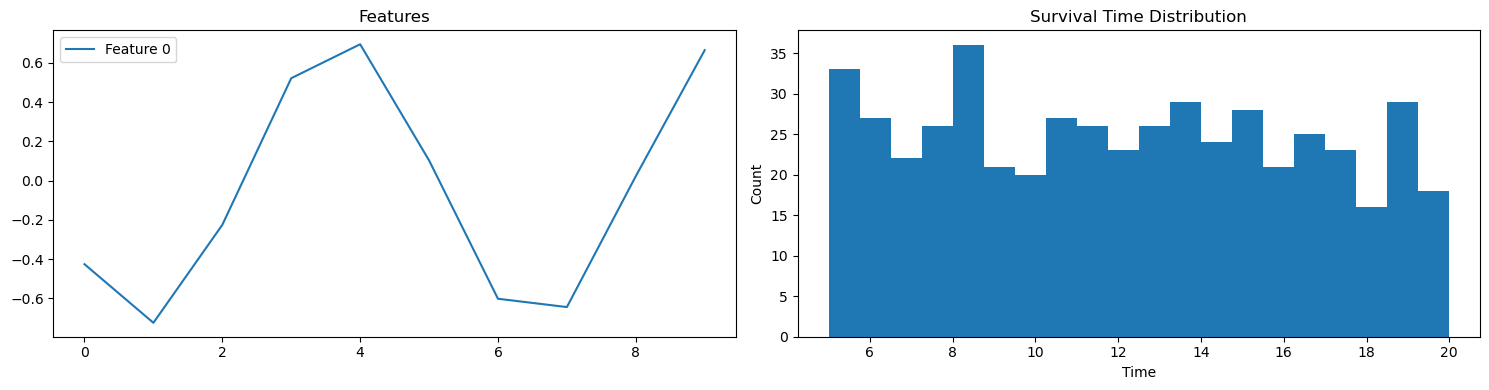

In [24]:
importlib.reload(ukko.data)

#Note: Move this class to ukko.data later
class SineWaveDatasetSurvival(ukko.data.SineWaveDataset):
    def __init__(self, n_samples, weibull_shape=1, weibull_scale=1, seed=42):
        """
        Creates sine wave dataset with survival times based on first feature's frequency, amplidue, or phase
        
        Args:
            n_samples: Number of samples in dataset
            weibull_shape: Shape parameter (k) for Weibull distribution
            weibull_scale: Scale parameter (lambda) for Weibull distribution
            seed: Random seed
        """
        # Init parent class with fixed parameters
        super().__init__(
            n_samples=n_samples,
            n_features=1,
            sequence_length=10,
            prediction_length=1,
            base_freq=0.1,
            noise_level=0.0,
            seed=seed
        )
        
        # Generate Weibull distributed survival times based on first feature frequency
        np.random.seed(seed)
        base_times = np.random.weibull(weibull_shape, n_samples) * weibull_scale
        
        # Scale times based on first feature's frequency. 
        # Note:
        #   - 1-p Weibull distribution is obtained: X = (-ln(U))^(1/k), where U is uniform [0,1] and k is the shape parameter.
        #   - 2-p Weibull inlcuding scale lambda is then: X = lambda * (-ln(U))^(1/k)
        freq_0 = np.array(self.f1f)  # Get frequencies of first feature, each smaple should havea a different frequency, but does not.
        A_samples = np.array(self.f1A) 
        #self.survival_times = np.multiply(base_times, A_samples)
        #self.survival_times = np.multiply(base_times, 2+self.groundtruth[:,0,1].numpy())
        #self.survival_times = 2+self.groundtruth[:,0,1].numpy()
        # make survival times deterministic:
        self.survival_times = 10*A_samples
        print(A_samples)
        
        # Generate random censoring
        # self.censoring = np.random.binomial(1, 0.3, n_samples)  # 30% censoring
        # Generate censoring (30% censored)
        self.events = np.random.binomial(1, 0.7, n_samples)

    def __getitem__(self, idx):
        x, _ = super().__getitem__(idx)
        event = torch.tensor(self.events[idx]).bool()
        time = torch.tensor(self.survival_times[idx]).float()
        return x, (event, time)

# Example usage:
if __name__ == "__main__":
    # Create dataset
    dataset = SineWaveDatasetSurvival(
        n_samples=500,
        weibull_shape=5.0,
        weibull_scale=10.0
    )
    
    # Get first sample
    x, (censoring, time) = dataset[0]
    
    # Plot example
    fig = plt.figure(figsize=(15, 4))
    
    # Plot features
    plt.subplot(121)
    for f in range(dataset.n_features):
        plt.plot(x[f], label=f'Feature {f}')
    plt.title('Features')
    plt.legend()
    
    # Plot survival time distribution
    plt.subplot(122)
    plt.hist(dataset.survival_times, bins=20)
    plt.title('Survival Time Distribution')
    plt.xlabel('Time')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

In [16]:
# Create artifical datasets for testing
train_dataset = SineWaveDatasetSurvival(n_samples=500, seed=42)
val_dataset = SineWaveDatasetSurvival(n_samples=500, seed=43)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify the data
print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# Check first batch
x, (event, time) = next(iter(train_loader))
print("\nFirst batch shapes:")
print(f"Features shape: {x.shape}")
print(f"Events shape: {event.shape}")
print(f"Times shape: {time.shape}")

Training samples: 500
Validation samples: 500

First batch shapes:
Features shape: torch.Size([32, 1, 10])
Events shape: torch.Size([32])
Times shape: torch.Size([32])


In [15]:
train_dataset.groundtruth[0,0,:]

tensor([-0.4264, -0.7254, -0.2259,  0.5223,  0.6955,  0.1032, -0.6027, -0.6452,
         0.0226,  0.6655,  0.5759])

## Baseline model coxPH from lifelines


#### Define functions


In [12]:
def get_risk_groups(model, data_loader, device='cpu'):
    """Get risk scores for all patients and split into high/low risk groups"""
    model.eval()
    all_risks = []
    all_times = []
    all_events = []
    
    with torch.no_grad():
        for x, durations, events in data_loader:
            x = x.float().to(device)
            hazard_ratios = model(x)
            # Ensure 1D arrays
            all_risks.append(hazard_ratios.cpu().numpy().flatten())
            all_times.append(durations.numpy().flatten())
            all_events.append(events.numpy().flatten())
    
    # Concatenate all predictions
    risk_scores = np.concatenate(all_risks)
    times = np.concatenate(all_times)
    events = np.concatenate(all_events)
    
    # Split into high/low risk groups using median
    median_risk = np.median(risk_scores)
    high_risk = risk_scores >= median_risk
    
    return risk_scores, times, events, high_risk

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def plot_risk_stratification(times, events, high_risk, title="Risk Stratification"):
    """Plot Kaplan-Meier curves for high and low risk groups"""
    
    # Initialize KM estimator
    kmf1 = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot high risk group
    mask = high_risk.astype(bool)  # Ensure boolean mask
    kmf1.fit(times[mask], events[mask], label='High Risk')
    kmf1.plot_survival_function(show_censors = True, censor_styles={'marker': 'x', 'ms': 15})
    
    # Plot low risk group
    mask = ~high_risk.astype(bool)  # Ensure boolean mask
    kmf2.fit(times[mask], events[mask], label='Low Risk')
    kmf2.plot_survival_function(show_censors = True, censor_styles={'marker': 'x', 'ms': 15})
    
    # Add at-risk counts
    lifelines.plotting.add_at_risk_counts(kmf1, kmf2)
    
    # Customize plot
    plt.title(title)
    plt.xlabel('Time (days)')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    
    # Add log-rank test
    from lifelines.statistics import logrank_test
    log_rank = logrank_test(times[high_risk], times[~high_risk],
                           events[high_risk], events[~high_risk])
    plt.text(0.05, 0.05, f'Log-rank p-value: {log_rank.p_value:.3e}',
             transform=plt.gca().transAxes)
    
    return plt.gcf()

### Data and model

In [13]:
df_train

,person_id,OSS_days,OSS_status,"('Basophils/100 leukocytes in Blood', -5.0)","('Basophils/100 leukocytes in Blood', -4.0)","('Basophils/100 leukocytes in Blood', -3.0)","('Basophils/100 leukocytes in Blood', -2.0)","('Basophils/100 leukocytes in Blood', -1.0)","('Basophils/100 leukocytes in Blood', 0.0)","('Basophils/100 leukocytes in Blood', 1.0)",...,"('Platelets [#/volume] in Blood', 12.0)","('Platelets [#/volume] in Blood', 13.0)","('Platelets [#/volume] in Blood', 14.0)","('Platelets [#/volume] in Blood', 15.0)","('Platelets [#/volume] in Blood', 16.0)","('Platelets [#/volume] in Blood', 17.0)","('Platelets [#/volume] in Blood', 18.0)","('Platelets [#/volume] in Blood', 19.0)","('Platelets [#/volume] in Blood', 20.0)","('Platelets [#/volume] in Blood', 21.0)"
0,32,2355.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,784,1672.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,61.5,28.0,18.0,73.0,40.0,18.0,75.0,37.0,20.0,5.0
2,7672,1.0,1,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,8029,2389.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,128.0,87.0,63.0,46.0,31.0,9.0,42.0,30.0,23.0,14.0
4,10452,8.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,3583450,3072.0,0,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,-1.0,...,25.0,43.0,27.0,48.0,40.0,27.0,-1.0,33.0,42.5,-1.0
1415,3593374,459.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,...,35.0,101.0,94.0,64.0,45.0,21.0,59.0,50.0,37.5,83.0
1416,3617077,3765.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1417,3631781,3748.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,208.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [14]:
import lifelines
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(df_train.drop(columns = ["person_id"]), duration_col='OSS_days', event_col='OSS_status')

#cph.print_summary()

<lifelines.CoxPHFitter: fitted with 919 total observations, 371 right-censored observations>

In [15]:
print(df_train.shape)
risk = cph.predict_partial_hazard(df_train.drop(columns = ["person_id"]))
print (risk)
print (np.median(risk))
high_risk = risk >= np.median(risk)

(919, 300)
0          1.140113
1          0.157569
2       1891.194366
3          1.745926
4          2.338361
           ...     
1414       0.115388
1415       0.322800
1416       0.591903
1417       0.372060
1418       0.421784
Length: 919, dtype: float64
0.9588638857341273


In [16]:
risk_threshholds = np.quantile(risk, [0.333, 0.666])
risk_strat = (risk > risk_threshholds[0]).astype(int) + (risk > risk_threshholds[1]).astype(int)
risk_strat

0       1
1       0
2       2
3       1
4       2
       ..
1414    0
1415    0
1416    1
1417    0
1418    0
Length: 919, dtype: int64

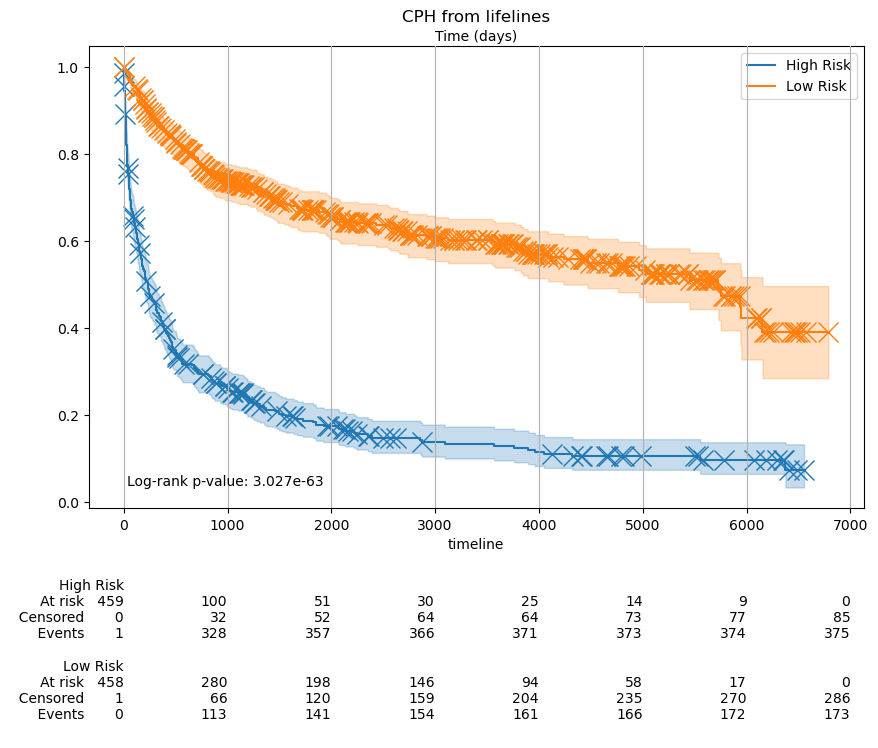

In [16]:
fig = plot_risk_stratification(df_train['OSS_days'], df_train['OSS_status'], high_risk, 
                             title="CPH from lifelines")

## Section 1: Classical loghazard model

### 1.1 Define model

In [17]:
cox_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(32, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 1),  # Estimating log hazards for Cox models
)
cox_model

Sequential(
  (0): BatchNorm1d(297, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=297, out_features=32, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=32, out_features=64, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=64, out_features=1, bias=True)
)

### 1.2 Train model

In [18]:
import warnings

warnings.filterwarnings("ignore")

In [19]:
torch.manual_seed(42)

# Init optimizer for Cox
optimizer = torch.optim.Adam(cox_model.parameters(), lr=LEARNING_RATE)

# Initiate empty list to store the loss on the train and validation sets
train_losses = []
val_losses = []

warnings.filterwarnings("ignore")

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for i, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        optimizer.zero_grad()
        log_hz = cox_model(x)  # shape = (16, 1)
        loss = neg_partial_log_likelihood(log_hz, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    #if epoch % (EPOCHS // 10) == 0:
    #    print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Reccord loss on train and test sets
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        epoch_val_loss = neg_partial_log_likelihood(cox_model(x), event, time, reduction="mean")
        val_losses.append(
          epoch_val_loss
        )

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}. Validation loss: {epoch_val_loss:0.2f}")

    epoch_loss /= i + 1
    

warnings.filterwarnings("default")

Epoch: 000, Training loss: 34.60. Validation loss: 5.50
Epoch: 003, Training loss: 33.32. Validation loss: 5.38
Epoch: 006, Training loss: 31.47. Validation loss: 5.50
Epoch: 009, Training loss: 31.62. Validation loss: 5.30
Epoch: 012, Training loss: 31.40. Validation loss: 5.46
Epoch: 015, Training loss: 29.89. Validation loss: 5.70
Epoch: 018, Training loss: 30.63. Validation loss: 5.61
Epoch: 021, Training loss: 29.77. Validation loss: 5.60
Epoch: 024, Training loss: 29.91. Validation loss: 5.92
Epoch: 027, Training loss: 29.74. Validation loss: 5.98


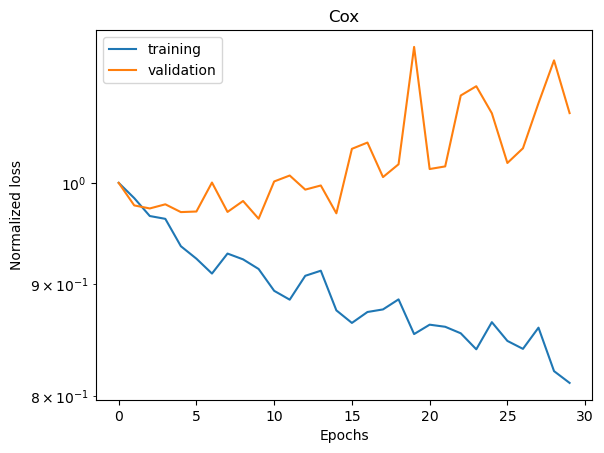

In [20]:
plot_losses(train_losses, val_losses, "Cox")

## Section 2: ukko

### 2.1 Prepare data

In [10]:
importlib.reload(ukko)
importlib.reload(ukko.utils)


<module 'ukko.utils' from '/mnt/batch/tasks/shared/LS_root/mounts/clusters/eric-gpu/code/Users/ext-dirk.fey/AzureRepos/ukko/ukko_2025_07_15/src/ukko/utils.py'>

In [11]:
## Test:

# Convert AML data to multiindex df
df_x, data_3d = ukko.utils.convert_to_3d_df(df_train.iloc[:,3:].fillna(-1))
df_y = df_train.iloc[:,:3]
#display(df_x)
#display(df_y)

In [12]:
df_train.head()

,person_id,OSS_days,OSS_status,"('Basophils/100 leukocytes in Blood', -5.0)","('Basophils/100 leukocytes in Blood', -4.0)","('Basophils/100 leukocytes in Blood', -3.0)","('Basophils/100 leukocytes in Blood', -2.0)","('Basophils/100 leukocytes in Blood', -1.0)","('Basophils/100 leukocytes in Blood', 0.0)","('Basophils/100 leukocytes in Blood', 1.0)",...,"('Platelets [#/volume] in Blood', 12.0)","('Platelets [#/volume] in Blood', 13.0)","('Platelets [#/volume] in Blood', 14.0)","('Platelets [#/volume] in Blood', 15.0)","('Platelets [#/volume] in Blood', 16.0)","('Platelets [#/volume] in Blood', 17.0)","('Platelets [#/volume] in Blood', 18.0)","('Platelets [#/volume] in Blood', 19.0)","('Platelets [#/volume] in Blood', 20.0)","('Platelets [#/volume] in Blood', 21.0)"
0,32,2355.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,784,1672.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,61.5,28.0,18.0,73.0,40.0,18.0,75.0,37.0,20.0,5.0
2,7672,1.0,1,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,8029,2389.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,128.0,87.0,63.0,46.0,31.0,9.0,42.0,30.0,23.0,14.0
4,10452,8.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [13]:
df_train.iloc[:,3:]

,"('Basophils/100 leukocytes in Blood', -5.0)","('Basophils/100 leukocytes in Blood', -4.0)","('Basophils/100 leukocytes in Blood', -3.0)","('Basophils/100 leukocytes in Blood', -2.0)","('Basophils/100 leukocytes in Blood', -1.0)","('Basophils/100 leukocytes in Blood', 0.0)","('Basophils/100 leukocytes in Blood', 1.0)","('Basophils/100 leukocytes in Blood', 2.0)","('Basophils/100 leukocytes in Blood', 3.0)","('Basophils/100 leukocytes in Blood', 4.0)",...,"('Platelets [#/volume] in Blood', 12.0)","('Platelets [#/volume] in Blood', 13.0)","('Platelets [#/volume] in Blood', 14.0)","('Platelets [#/volume] in Blood', 15.0)","('Platelets [#/volume] in Blood', 16.0)","('Platelets [#/volume] in Blood', 17.0)","('Platelets [#/volume] in Blood', 18.0)","('Platelets [#/volume] in Blood', 19.0)","('Platelets [#/volume] in Blood', 20.0)","('Platelets [#/volume] in Blood', 21.0)"
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,61.5,28.0,18.0,73.0,40.0,18.0,75.0,37.0,20.0,5.0
2,-1.0,-1.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,128.0,87.0,63.0,46.0,31.0,9.0,42.0,30.0,23.0,14.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,-1.0,-1.0,-1.0,2.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,...,25.0,43.0,27.0,48.0,40.0,27.0,-1.0,33.0,42.5,-1.0
1415,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,...,35.0,101.0,94.0,64.0,45.0,21.0,59.0,50.0,37.5,83.0
1416,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1417,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,208.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [16]:
data_3d.shape

(919, 11, 27)

In [17]:
df_x.columns.get_level_values(0).to_frame().drop_duplicates()

,Feature
Feature,
Basophils/100 leukocytes in Blood,Basophils/100 leukocytes in Blood
Blasts/100 cells in Bone marrow,Blasts/100 cells in Bone marrow
Blasts/100 leukocytes in Blood,Blasts/100 leukocytes in Blood
Eosinophils/100 leukocytes in Blood,Eosinophils/100 leukocytes in Blood
Hemoglobin [Mass/volume] in Blood,Hemoglobin [Mass/volume] in Blood
Lactate dehydrogenase [Enzymatic activity/volume] in Serum or Plasma by Lactate to pyruvate reaction,Lactate dehydrogenase [Enzymatic activity/volu...
Leukocytes [#/volume] in Blood,Leukocytes [#/volume] in Blood
Lymphocytes/100 leukocytes in Blood,Lymphocytes/100 leukocytes in Blood
Monocytes/100 leukocytes in Blood,Monocytes/100 leukocytes in Blood


In [18]:
data_3d.shape

(919, 11, 27)

In [19]:
idx = [0, 1, 3]
torch.tensor(data_3d[idx,:,:]).shape

torch.Size([3, 11, 27])

In [14]:
class ukkosurv_dataset(Dataset):
    """ "Custom dataset for ukko-torcsurv use in df format"""

    # defining values in the constructor
    def __init__(self, df: pd.DataFrame):
        #self.df = df
        df_x, data_3d = ukko.utils.convert_to_3d_df(df.iloc[:,3:].fillna(-1))
        df_y = df.iloc[:,:3]
        
        self.df_y = df_y        # Dataframe with survival data, e.g. OSS_status, OSS_days
        self.data_3d = data_3d  # numpy array with 3D feature data: patients, features, time 


    # Getting data size/length
    def __len__(self):
        return len(self.data_3d)

    # Getting the data samples
    def __getitem__(self, idx):
        y = self.df_y.iloc[idx,:]
        # Targets
        event = torch.tensor(y["OSS_status"]).bool()
        time = torch.tensor(y["OSS_days"]).float()
        # Predictors
        x = torch.tensor(self.data_3d[idx,:,:]).float()
        return x, (event, time)

In [15]:
# Dataloader
BATCH_SIZE = 600
BATCH_SIZE = len(df_train)
dataloader_train = DataLoader(
    ukkosurv_dataset(df_train), batch_size=BATCH_SIZE, shuffle=True
)
dataloader_val = DataLoader(
    ukkosurv_dataset(df_val), batch_size=len(df_val), shuffle=False
)
dataloader_test = DataLoader(
    ukkosurv_dataset(df_test), batch_size=len(df_test), shuffle=False
)

In [21]:
#help(dataloader_train)

In [16]:
# Sanity check
x, (event, time) = next(iter(dataloader_train))
num_features, num_timepoints = x.size(1), x.size(2)

print(f"x (shape)      = {x.shape}")
print(f"num_features   = {num_features}")
print(f"num_timepoints = {num_timepoints}")
print(f"event          = {event.shape}")
print(f"time           = {time.shape}")

x (shape)      = torch.Size([919, 11, 27])
num_features   = 11
num_timepoints = 27
event          = torch.Size([919])
time           = torch.Size([919])


### 2.1 Artifical dataset for testing

In [242]:
# Create artifical datasets for testing
train_dataset = SineWaveDatasetSurvival(n_samples=500, seed=42)
val_dataset = SineWaveDatasetSurvival(n_samples=500, seed=43)

# Asing paramters for model accordingly:
num_features   = train_dataset.n_features
num_timepoints = train_dataset.sequence_length

# Create dataloaders
batch_size = 500
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify the data
print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# Check first batch
x, (event, time) = next(iter(dataloader_train))
print("\nFirst batch shapes:")
print(f"Features shape: {x.shape}")
print(f"Events shape: {event.shape}")
print(f"Times shape: {time.shape}")

Training samples: 500
Validation samples: 500

First batch shapes:
Features shape: torch.Size([500, 1, 10])
Events shape: torch.Size([500])
Times shape: torch.Size([500])


21

### 2.2 Define model

In [17]:
importlib.reload(ukko.core)

try:
    del model
except:
    pass
try:
    del optimizer
except:
    pass
    
# Initialize model
# DualAttentionRegressor1(self, n_features, time_steps, d_model=128, n_heads=8, dropout=0.1, n_modules=1)
model = ukko.core.DualAttentionRegressor1(
    n_features=num_features,
    time_steps=num_timepoints,
    d_model=16,
    n_heads=4,
    dropout=0.2,
    n_modules=2
)
model

DualAttentionRegressor1(
  (modules_list): ModuleList(
    (0-1): 2 x DualAttentionModule(
      (input_projection): Linear(in_features=1, out_features=16, bias=True)
      (pos_encoder): PositionalEncoding()
      (feature_attention): MultiHeadAttention(
        (W_q): Linear(in_features=16, out_features=16, bias=True)
        (W_k): Linear(in_features=16, out_features=16, bias=True)
        (W_v): Linear(in_features=16, out_features=16, bias=True)
        (W_o): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (feature_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (feature_ff_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (time_attention): MultiHeadAttention(
        (W_q): Linear(in_features=16, out_features=16, bias=True)
        (W_k): Linear(in_features=16, out_features=16, bias=True)
        (W_v): Linear(in_features=16, out_features=16, bias=True)
        (W_o): Linear(in_fea

In [18]:
# Sanity check:

def sanity_check(model, dataloader):
    """
    Perform basic model sanity checks
    """
    # Get a single batch
    batch, (event, time) = next(iter(dataloader))
    
    print("Input shapes:")
    print(f"Batch: {batch.shape}")
    print(f"Event: {event.shape}")
    print(f"Time: {time.shape}")
    
    # Run forward pass
    try:
        predictions, feat_attn, time_attn = model(batch)
        print("\nOutput shapes:")
        print(f"Predictions: {predictions.shape}")
        print(f"Feature attention: {feat_attn.shape}")
        print(f"Time attention: {time_attn.shape}")
        
        print("\nValue ranges:")
        print(f"Predictions min/max: {predictions.min():.3f}/{predictions.max():.3f}")
        print(f"Feature attention min/max: {feat_attn.min():.3f}/{feat_attn.max():.3f}")
        print(f"Time attention min/max: {time_attn.min():.3f}/{time_attn.max():.3f}")
        
        return True
    except Exception as e:
        print(f"Error during forward pass: {str(e)}")
        return False

# Run sanity check
success = sanity_check(model, dataloader_train)

Input shapes:
Batch: torch.Size([919, 11, 27])
Event: torch.Size([919])
Time: torch.Size([919])

Output shapes:
Predictions: torch.Size([919])
Feature attention: torch.Size([24813, 4, 11, 11])
Time attention: torch.Size([10109, 4, 27, 27])

Value ranges:
Predictions min/max: -0.362/0.069
Feature attention min/max: 0.000/0.504
Time attention min/max: 0.000/0.285


### 2.3 Model training

In [19]:
model_parameters = sum(p.numel() for p in model.parameters())
model_memory = model_parameters * 4 / (1024 ** 2)  # in MB
print(f"Model_memory {model_memory} MB")

Model_memory 0.7916755676269531 MB


In [36]:
def analyze_model_parameters(model):
    """Analyze model parameters and their shapes"""
    total_params = 0
    print("Model Parameter Analysis:")
    print("-" * 80)
    print(f"{'Layer':<50} {'Shape':<20} {'Parameters':<10}")
    print("-" * 80)
    
    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params
        print(f"{name:<50} {str(list(param.shape)):<20} {num_params:<10,d}")
    
    print("-" * 80)
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Run the analysis
analyze_model_parameters(model)

Model Parameter Analysis:
--------------------------------------------------------------------------------
Layer                                              Shape                Parameters
--------------------------------------------------------------------------------
modules_list.0.input_projection.weight             [16, 1]              16        
modules_list.0.input_projection.bias               [16]                 16        
modules_list.0.feature_attention.W_q.weight        [16, 16]             256       
modules_list.0.feature_attention.W_q.bias          [16]                 16        
modules_list.0.feature_attention.W_k.weight        [16, 16]             256       
modules_list.0.feature_attention.W_k.bias          [16]                 16        
modules_list.0.feature_attention.W_v.weight        [16, 16]             256       
modules_list.0.feature_attention.W_v.bias          [16]                 16        
modules_list.0.feature_attention.W_o.weight        [16, 16]      

In [20]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())


0
0
0
0


/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/torchsurv/loss/cox.py:222: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(


Epoch: 000, Training loss: 8.39, Validation loss: 5.43
Epoch: 005, Training loss: 8.37, Validation loss: 5.31
Epoch: 010, Training loss: 8.35, Validation loss: 5.77
Epoch: 015, Training loss: 8.66, Validation loss: 5.56
Epoch: 020, Training loss: 8.66, Validation loss: 5.55
Epoch: 025, Training loss: 8.66, Validation loss: 5.55
Epoch: 030, Training loss: 8.66, Validation loss: 5.55
Epoch: 035, Training loss: 8.65, Validation loss: 5.53
Epoch: 040, Training loss: 8.60, Validation loss: 5.46
Epoch: 045, Training loss: 8.58, Validation loss: 5.45
Epoch: 050, Training loss: 8.56, Validation loss: 5.44
Epoch: 055, Training loss: 8.55, Validation loss: 5.43
Epoch: 060, Training loss: 8.55, Validation loss: 5.62
Epoch: 065, Training loss: 8.55, Validation loss: 5.44
Epoch: 070, Training loss: 8.55, Validation loss: 5.43
Epoch: 075, Training loss: 8.54, Validation loss: 5.42
Epoch: 080, Training loss: 8.55, Validation loss: 5.42
Epoch: 085, Training loss: 8.51, Validation loss: 5.38
Epoch: 090

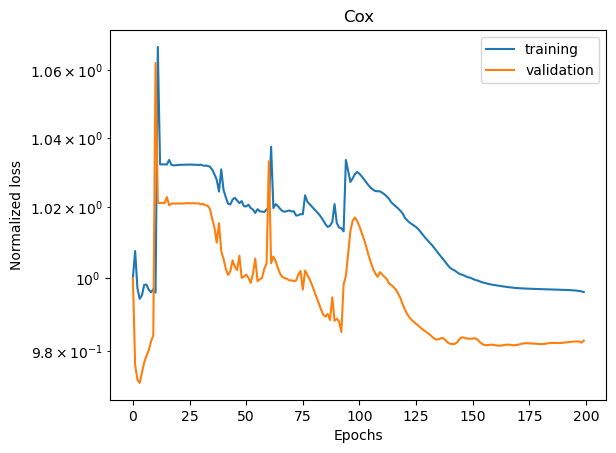

In [43]:
torch.manual_seed(42)

EPOCHS = 200
LEARNING_RATE = 2e-2

# Init optimizer for Cox
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Initiate empty list to store the loss on the train and validation sets
train_losses = []
val_losses = []

# Get device and move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for i, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        x = x.to(device)
        optimizer.zero_grad()
        log_hz, feature_weights, time_weights = model(x)  # shape = (batchsize, 1)
        loss = neg_partial_log_likelihood(log_hz.to(device), event.to(device), time.to(device), reduction="mean")
        #print(loss.is_cuda)
        #print(epoch_loss.is_cuda)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().to("cpu")

    # Reccord loss on train and test sets
    epoch_loss /= i + 1
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        x = x.to(device)
        log_hz, feature_weights, time_weights = model(x)
        val_losses.append(
            neg_partial_log_likelihood(log_hz, event, time, reduction="mean").detach().to("cpu")
        )

    # Display progress
    if epoch % 5 == 0: #(EPOCHS // 5) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {train_losses[-1]:0.2f}, Validation loss: {val_losses[-1]:0.2f}")

plot_losses(train_losses, val_losses, "Cox")

Cox model performance:
Concordance-index   = 0.6971320509910583
Confidence interval = tensor([0.6471, 0.7472])


Text(0, 0.5, 'Log hazard')

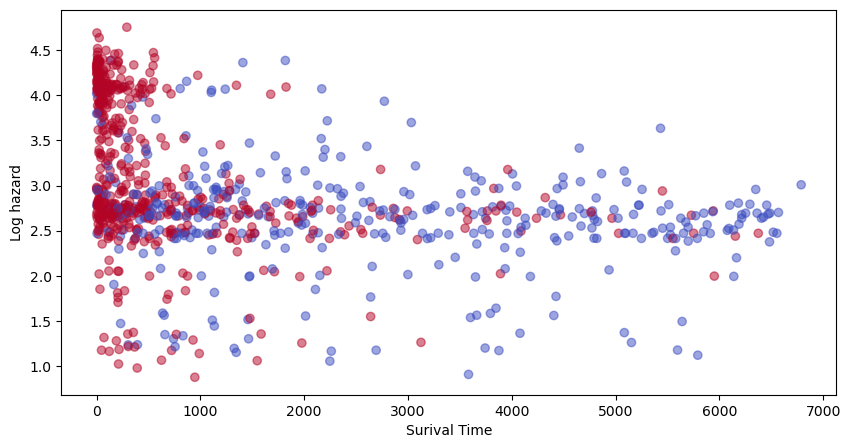

In [44]:
model = model.to("cpu")
model.eval()
with torch.no_grad():
    # test event and test time of length n
    x, (event, time) = next(iter(dataloader_train))
    x = x.to("cpu")
    log_hz, feature_weights, time_weights = model(x)  # log hazard of length n

# Concordance index
cox_cindex = ConcordanceIndex()
print("Cox model performance:")
print(f"Concordance-index   = {cox_cindex(log_hz, event, time)}")
print(f"Confidence interval = {cox_cindex.confidence_interval()}")

# plot log hazard vs time
plt.figure(figsize=(10, 5))
# change to scatter plot and color by event 
plt.scatter(time, log_hz, c=event, cmap='coolwarm', alpha=0.5)
plt.xlabel("Surival Time")
plt.ylabel("Log hazard")



In [86]:
x.shape

torch.Size([600, 11, 27])

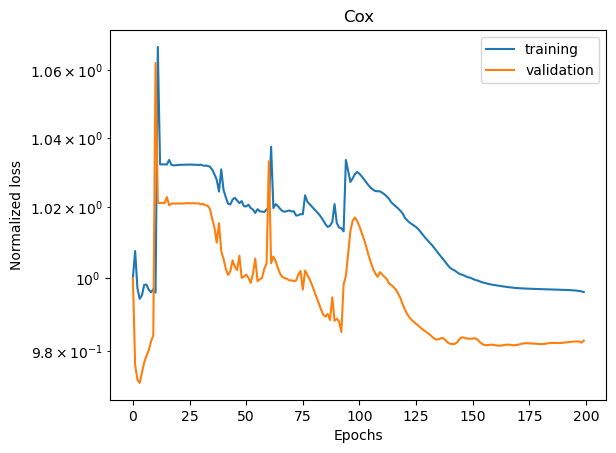

In [45]:
plot_losses(train_losses, val_losses, "Cox")

In [49]:
model.parameters()

<generator object Module.parameters at 0x000001B074C4FCA0>

#### Model performance

In [66]:
risk = log_hz.detach().cpu().numpy()
risk_threshholds = np.quantile(risk, [0.333, 0.666])
risk_threshholds = np.quantile(risk, [0.5, 1])
risk_strat = (risk > risk_threshholds[0]).astype(int) + (risk  > risk_threshholds[1]).astype(int)

In [46]:
model = model.to("cpu")
model.eval()
with torch.no_grad():
    # test event and test time of length n
    x = torch.tensor(ukkosurv_dataset(df_train).data_3d).float()
    #x, (event, time) = next(iter(dataloader_train))
    x = x.to("cpu")
    log_hz, feature_weights, time_weights = model(x)

risk = log_hz.detach().cpu().numpy()
high_risk = risk >= np.median(risk)

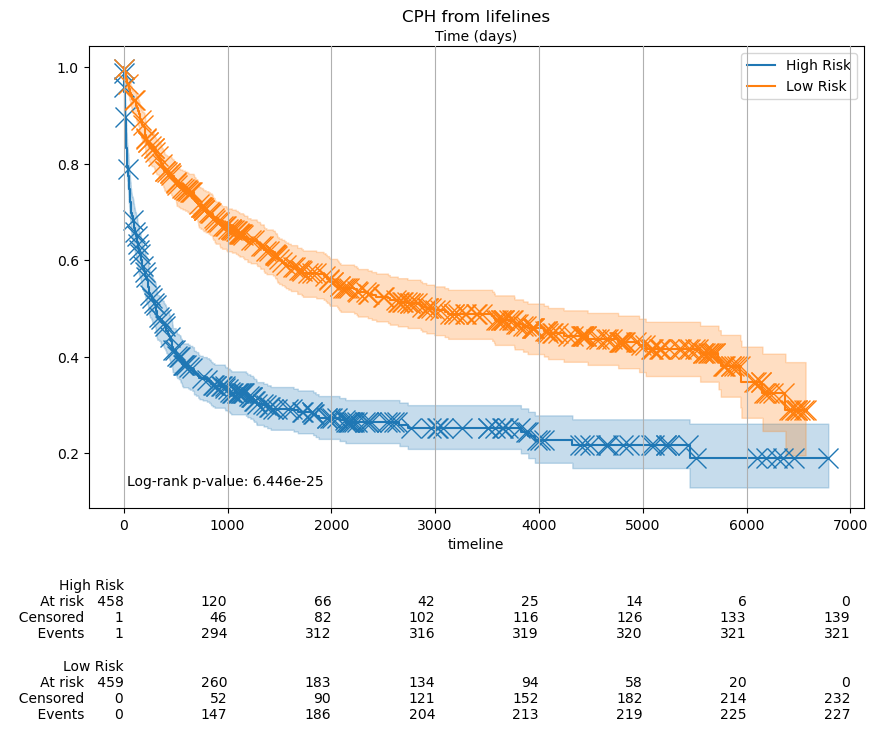

In [47]:
warnings.filterwarnings("ignore")
fig = plot_risk_stratification(df_train['OSS_days'], df_train['OSS_status'], high_risk, 
                             title="CPH from lifelines")
warnings.filterwarnings("default")

In [163]:
display(df_val)

uk_val = ukkosurv_dataset(df_val)
uk_val.__dict__

,person_id,OSS_days,OSS_status,"('Basophils/100 leukocytes in Blood', -5.0)","('Basophils/100 leukocytes in Blood', -4.0)","('Basophils/100 leukocytes in Blood', -3.0)","('Basophils/100 leukocytes in Blood', -2.0)","('Basophils/100 leukocytes in Blood', -1.0)","('Basophils/100 leukocytes in Blood', 0.0)","('Basophils/100 leukocytes in Blood', 1.0)",...,"('Platelets [#/volume] in Blood', 12.0)","('Platelets [#/volume] in Blood', 13.0)","('Platelets [#/volume] in Blood', 14.0)","('Platelets [#/volume] in Blood', 15.0)","('Platelets [#/volume] in Blood', 16.0)","('Platelets [#/volume] in Blood', 17.0)","('Platelets [#/volume] in Blood', 18.0)","('Platelets [#/volume] in Blood', 19.0)","('Platelets [#/volume] in Blood', 20.0)","('Platelets [#/volume] in Blood', 21.0)"
836,2048440,870.0,1,-1.0,4.0,7.0,-1.0,4.0,5.0,7.0,...,22.0,28.0,17.0,14.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1354,3350431,450.0,1,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,232.0,-1.0,-1.0,-1.0,205.0,190.0,-1.0,190.0
71,194760,1062.0,0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,...,124.0,105.0,98.0,79.0,85.0,70.0,75.0,76.0,-1.0,-1.0
86,219503,2076.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0,...,22.0,13.0,30.0,29.0,35.0,13.0,48.0,13.0,81.0,31.0
1252,3086117,27.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,...,114.0,-1.0,78.0,79.0,69.0,74.0,83.0,73.0,55.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,2760137,32.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,41.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,29.0,-1.0
956,2360335,173.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,...,31.0,31.0,37.0,25.0,34.0,-1.0,31.0,43.0,32.0,23.0
346,856666,8.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
504,1228469,4958.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,...,85.0,63.0,59.0,37.0,38.0,51.0,36.0,86.0,55.0,44.0


{'df_y':       person_id  OSS_days  OSS_status
 836     2048440     870.0           1
 1354    3350431     450.0           1
 71       194760    1062.0           0
 86       219503    2076.0           0
 1252    3086117      27.0           1
 ...         ...       ...         ...
 1107    2760137      32.0           1
 956     2360335     173.0           1
 346      856666       8.0           0
 504     1228469    4958.0           0
 1340    3301990       1.0           1
 
 [250 rows x 3 columns],
 'data_3d': array([[[ -1.,   4.,   7., ...,  -1.,  -1.,  -1.],
         [ -1.,  -1.,  -1., ...,  -1.,  -1.,  -1.],
         [ -1.,  22.,  23., ...,  -1.,  -1.,  -1.],
         ...,
         [ -1.,   2.,   3., ...,  -1.,  -1.,  -1.],
         [ -1.,  16.,  17., ...,  -1.,  -1.,  -1.],
         [ 77.,  78.,  61., ...,  -1.,  -1.,  -1.]],
 
        [[ -1.,  -1.,   1., ...,   0.,  -1.,  -1.],
         [ -1.,  -1.,  -1., ...,  -1.,  -1.,  -1.],
         [ -1.,  -1.,  -1., ...,  -1.,  -1.,  -1.],
 

tensor([ 870.,  450., 1062., 2076.])
tensor([ True,  True, False, False])
[ 870.  450. 1062. 2076.]
[ True  True False False]
[ 870.  450. 1062. 2076.]
[1 1 0 0]


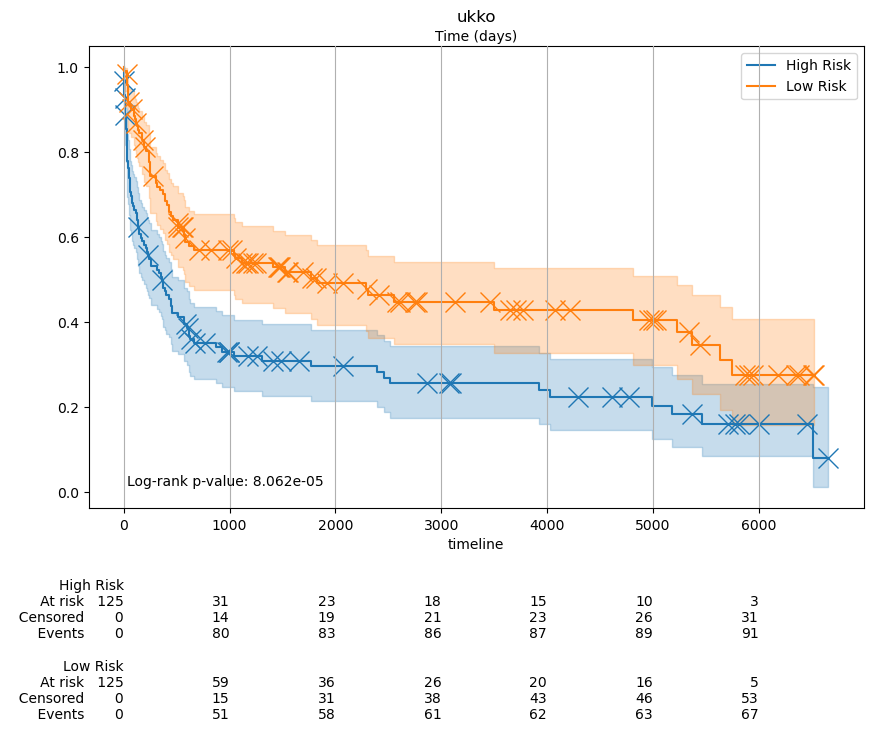

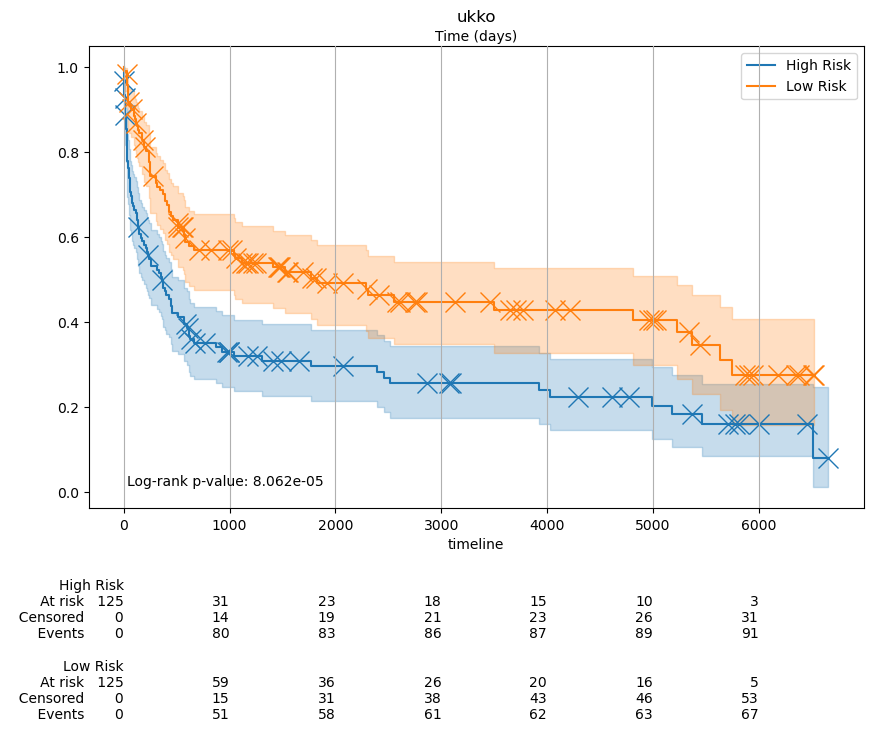

In [42]:
model = model.to("cpu")
model.eval()
with torch.no_grad():
    # test event and test time of length n
    x, (event, time) = next(iter(dataloader_val))
    x = x.to("cpu")
    log_hz, feature_weights, time_weights = model(x)
    print(time[:4])
    print(event[:4])

print(time.numpy()[:4])
print(event[:4].numpy())

print(df_val['OSS_days'][:4].to_numpy())
print(df_val['OSS_status'][:4].to_numpy())


risk = log_hz.detach().cpu().numpy()
high_risk = risk >= np.median(risk)

warnings.filterwarnings("ignore")
fig = plot_risk_stratification(time, event, high_risk, 
                             title="ukko")
fig = plot_risk_stratification(df_val['OSS_days'], df_val['OSS_status'], high_risk, 
                             title="ukko")
warnings.filterwarnings("default")

### 2.4 Weibull-ukko 

This means 2 outputs of model: shape and scale. 

In [277]:
# Create Weibull model

importlib.reload(ukko.core)

# Initialize model
# DualAttentionRegressor1(self, n_features, time_steps, d_model=128, n_heads=8, dropout=0.1, n_modules=1)
model = ukko.core.DualAttentionRegressor1(
    n_features=num_features,
    time_steps=num_timepoints,
    d_model=16,
    n_heads=4,
    dropout=0.2,
    n_modules=2,
    n_outputs=2 # output for log shape and log scale of Weibull
)
model

DualAttentionRegressor1(
  (modules_list): ModuleList(
    (0-1): 2 x DualAttentionModule(
      (input_projection): Linear(in_features=1, out_features=16, bias=True)
      (pos_encoder): PositionalEncoding()
      (feature_attention): MultiHeadAttention(
        (W_q): Linear(in_features=16, out_features=16, bias=True)
        (W_k): Linear(in_features=16, out_features=16, bias=True)
        (W_v): Linear(in_features=16, out_features=16, bias=True)
        (W_o): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (feature_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (feature_ff_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (time_attention): MultiHeadAttention(
        (W_q): Linear(in_features=16, out_features=16, bias=True)
        (W_k): Linear(in_features=16, out_features=16, bias=True)
        (W_v): Linear(in_features=16, out_features=16, bias=True)
        (W_o): Linear(in_fea

In [299]:
# Training of Weibull model

torch.manual_seed(42)

EPOCHS = 60
LEARNING_RATE = 1e-2

# Init optimizer for Cox
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Initiate empty list to store the loss on the train and validation sets
train_losses = []
val_losses = []

# Get device and move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for i, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        x.to(device)
        optimizer.zero_grad()
        log_params, feature_weights, time_weights = model(x)  
        loss = neg_log_likelihood(log_params, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    # Reccord loss on train and test sets
    epoch_loss /= i + 1
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        log_params, feature_weights, time_weights = model(x)
        val_losses.append(
            neg_log_likelihood(log_params, event, time, reduction="mean")
        )

    # Display progress
    #if epoch % (EPOCHS // 10) == 0:
    print(f"Epoch: {epoch:03}, Training loss: {train_losses[-1]:0.2f}, Validation loss: {val_losses[-1]:0.2f}")

Epoch: 000, Training loss: 1.72, Validation loss: 13.35
Epoch: 001, Training loss: 10.66, Validation loss: 2.55
Epoch: 002, Training loss: 1.67, Validation loss: 1.97
Epoch: 003, Training loss: 2.07, Validation loss: 2.71
Epoch: 004, Training loss: 3.00, Validation loss: 3.29
Epoch: 005, Training loss: 3.58, Validation loss: 3.47
Epoch: 006, Training loss: 3.78, Validation loss: 3.33
Epoch: 007, Training loss: 3.62, Validation loss: 3.02
Epoch: 008, Training loss: 3.28, Validation loss: 2.68
Epoch: 009, Training loss: 2.92, Validation loss: 2.39
Epoch: 010, Training loss: 2.60, Validation loss: 2.20
Epoch: 011, Training loss: 2.36, Validation loss: 2.19
Epoch: 012, Training loss: 2.29, Validation loss: 2.29
Epoch: 013, Training loss: 2.33, Validation loss: 2.35
Epoch: 014, Training loss: 2.37, Validation loss: 2.32
Epoch: 015, Training loss: 2.32, Validation loss: 2.24
Epoch: 016, Training loss: 2.25, Validation loss: 2.15
Epoch: 017, Training loss: 2.17, Validation loss: 2.07
Epoch: 0

Weibull model performance:
Concordance-index   = 0.835179328918457
Confidence interval = tensor([0.8045, 0.8658])
p-value             = 0.0


Text(0, 0.5, 'Scale parameter (log scale)')

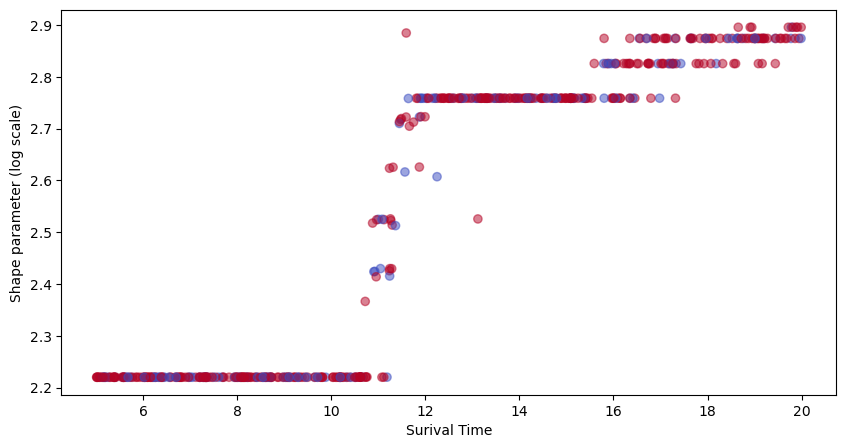

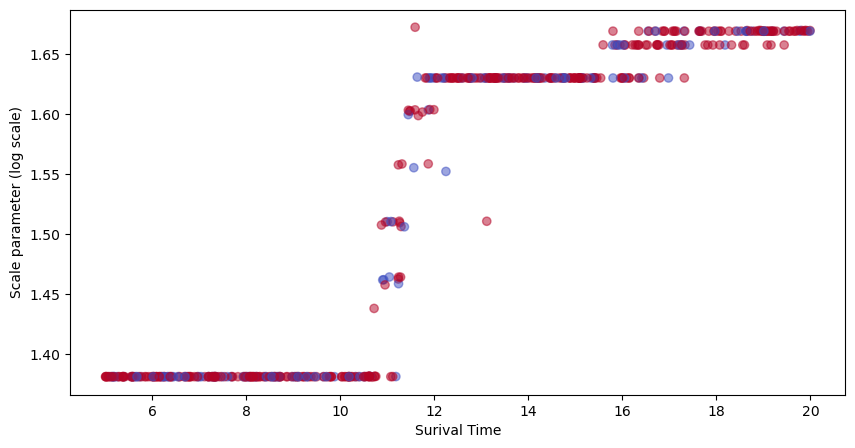

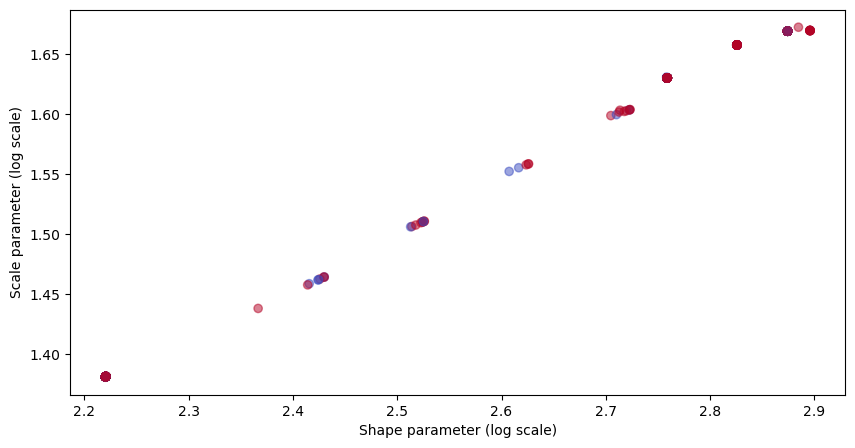

In [300]:
model.eval()
with torch.no_grad():
    # test event and test time of length n
    x, (event, time) = next(iter(dataloader_train))
    log_params, feature_weights, time_weights = model(x)  # log hazard of length n

# Additional step for Weibull:
# Compute the log hazards from weibull log parameters
log_hz = log_hazard(log_params, time)  
# Compute the survival probability from weibull log parameters
surv = survival_function(log_params, time)  

# Concordance index
weibull_cindex = ConcordanceIndex()
print("Weibull model performance:")
print(f"Concordance-index   = {weibull_cindex(log_hz, event, time)}")
print(f"Confidence interval = {weibull_cindex.confidence_interval()}")

# H0: cindex = 0.5, Ha: cindex >0.5
print(f"p-value             = {weibull_cindex.p_value(alternative = 'greater')}")

# plot log hazard vs time
plt.figure(figsize=(10, 5))
# change to scatter plot and color by event 
plt.scatter(time, log_params[:,0], c=event, cmap='coolwarm', alpha=0.5)
plt.xlabel("Surival Time")
plt.ylabel("Shape parameter (log scale)")

plt.figure(figsize=(10, 5))
# change to scatter plot and color by event 
plt.scatter(time, log_params[:,1], c=event, cmap='coolwarm', alpha=0.5)
plt.xlabel("Surival Time")
plt.ylabel("Scale parameter (log scale)")

plt.figure(figsize=(10, 5))
# change to scatter plot and color by event 
plt.scatter(log_params[:,0], log_params[:,1], c=event, cmap='coolwarm', alpha=0.5)
plt.xlabel("Shape parameter (log scale)")
plt.ylabel("Scale parameter (log scale)")



In [283]:
log_hz.shape

torch.Size([500, 500])

## Section 3: Hyperparameter search for ukko PH

In [62]:
import copy

def train_model_simple(
            model,
            dataloader_train,
            dataloader_val,
            optimizer = None,
            n_epochs = 100,
            learning_rate = 0.001,
            device='cuda'
        ):

    # Initialize optimizer if not provided
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initiate empty list to store the loss on the train and validation sets
    train_losses = []
    val_losses = []
    best_loss = float('inf')
    best_model_state = None
    
    # Get device and move model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # training loop
    for epoch in range(n_epochs):
        epoch_loss = torch.tensor(0.0)
        model = model.to(device)
        for i, batch in enumerate(dataloader_train):
            x, (event, time) = batch
            x = x.to(device)
            optimizer.zero_grad()
            log_hz, feature_weights, time_weights = model(x)  # shape = (batchsize, 1)
            loss = neg_partial_log_likelihood(log_hz.to(device), event.to(device), time.to(device), reduction="mean")
            #print(loss.is_cuda)
            #print(epoch_loss.is_cuda)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.detach().to("cpu").item()
    
        # Reccord loss on train and test sets
        epoch_loss /= i + 1
        train_losses.append(epoch_loss)
        model.eval()
        with torch.no_grad():
            x, (event, time) = next(iter(dataloader_val))
            x = x.to(device)
            log_hz, feature_weights, time_weights = model(x)
            val_loss = neg_partial_log_likelihood(log_hz, event, time, reduction="mean").detach().to("cpu")
            val_losses.append(val_loss)
            # Save best model based on validation loss
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_state = copy.deepcopy(model.to('cpu').state_dict())
    
        # Display progress
        if epoch % 10 == 0: #(n_epochs // 5) == 0:
            print(f"    Epoch: {epoch:03}, Training loss: {train_losses[-1]:0.2f}, Validation loss: {val_losses[-1]:0.2f}")
    
    # Load best model if validation was used
    if dataloader_val and best_model_state:
        model.load_state_dict(best_model_state)

    del x, event, time, log_hz, feature_weights, time_weights, loss
    gc.collect()
    
    return model, train_losses, val_losses, best_loss #if dataloader_val else avg_train_loss.item()

In [36]:
# for cuda memory management:
import torch
import gc

def print_cuda_tensors():
    """
    Prints a list of all tensors currently residing on the CUDA device.
    """
    print("--- CUDA Tensors ---")
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda:
                # Calculate memory in megabytes (MB)
                mem_bytes = obj.element_size() * obj.nelement()
                mem_mb = mem_bytes / (1024 ** 2)
                
                print(f"Type: {obj.type():<30s} | Size: {str(list(obj.size())):<20s} | Mem: {mem_mb:.2f} MB")
        except:
            # Some objects may fail attribute lookups
            pass
    print("--------------------")

In [40]:
gc.collect()

5738

In [41]:
# --- Example Usage ---
# Create some tensors on the CPU and GPU
a = torch.randn(100, 100)
b = torch.randn(1000, 1000, device='cuda')
c = torch.zeros((5, 2048, 2048), dtype=torch.float16, device='cuda')

# Now let's see what's on the GPU
print_cuda_tensors()

# Output might look like this:
# --- CUDA Tensors ---
# Type: torch.cuda.FloatTensor          | Size: [1000, 1000]         | Mem: 3.81 MB
# Type: torch.cuda.HalfTensor           | Size: [5, 2048, 2048]      | Mem: 40.00 MB
# --------------------

# If we delete a tensor, it will disappear from the list after Python's garbage collection
del c
# gc.collect() # Optionally force garbage collection
print_cuda_tensors()

# Output now only shows tensor 'b':
# --- CUDA Tensors ---
# Type: torch.cuda.FloatTensor          | Size: [1000, 1000]         | Mem: 3.81 MB
# --------------------

--- CUDA Tensors ---
Type: torch.cuda.FloatTensor         | Size: [1000, 1000]         | Mem: 3.81 MB
Type: torch.cuda.HalfTensor          | Size: [5, 2048, 2048]      | Mem: 40.00 MB
Type: torch.cuda.FloatTensor         | Size: [24813, 11, 8]       | Mem: 8.33 MB
Type: torch.cuda.FloatTensor         | Size: [24813, 11, 4, 2]    | Mem: 8.33 MB
Type: torch.cuda.FloatTensor         | Size: [24813, 11, 8]       | Mem: 8.33 MB
Type: torch.cuda.FloatTensor         | Size: [10109, 27, 8]       | Mem: 8.33 MB
Type: torch.cuda.FloatTensor         | Size: [10109, 27, 4, 2]    | Mem: 8.33 MB
Type: torch.cuda.FloatTensor         | Size: [10109, 27, 8]       | Mem: 8.33 MB
Type: torch.cuda.FloatTensor         | Size: [1000, 1000]         | Mem: 3.81 MB
Type: torch.cuda.FloatTensor         | Size: [919, 11, 27]        | Mem: 1.04 MB
Type: torch.cuda.FloatTensor         | Size: [919, 11, 27, 1]     | Mem: 1.04 MB
Type: torch.cuda.FloatTensor         | Size: [1]                  | Mem: 0.00 MB
Type: 

In [63]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import itertools

def hyperparameter_search(model_class, dataloader_train, dataloader_val, param_grid):
    """
    Perform grid search over hyperparameters
    
    Args:
        model_class: The model class to instantiate
        dataloader_train: DataLoader for training data
        dataloader_val: DataLoader for validation data
        param_grid: Dictionary of parameters to search, e.g.:
            {
                'learning_rate': [0.1, 0.01, 0.001],
                'd_model': [8, 16, 32],
                'n_heads': [4, 8],
                'n_modules':[1,2,3],
                'dropout': [0.1, 0.2]
            }
    """
    # Generate all combinations of parameters
    param_combinations = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    best_val_loss = float('inf')
    best_params = None
    best_model_state = None

    # Get model/data dimensions
    x, (event, time) = next(iter(dataloader_train))
    num_features, num_timepoints = x.size(1), x.size(2)

    # list of dicts for results:
    results = []
    
    # Try each parameter combination
    for params in param_combinations:
        # Initialize model with current parameters
        model = model_class(
            n_features=num_features,
            time_steps=num_timepoints,
            d_model=params['d_model'],
            n_heads=params['n_heads'],
            n_modules=params['n_modules'],
            dropout=params['dropout']
        )
        # Notes: 
        # model = ukko.core.DualAttentionRegressor1(
        #     n_features=num_features,
        #     time_steps=num_timepoints,
        #     d_model=16,
        #     n_heads=4,
        #     dropout=0.2,
        #     n_modules=2
        # )
        
        # Initialize optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        
        # Train model
        trained_model, train_losses, val_losses, val_loss = train_model_simple(
            model=model,
            dataloader_train = dataloader_train,
            dataloader_val = dataloader_val, 
            optimizer=optimizer,
            n_epochs=5,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )

        # Keep result
        results.append(
            {
            'params': params,
            'val_loss': val_loss.detach().cpu().numpy()
            }
        )
        
        # Update best parameters if current model is better
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = params
            best_model_state = trained_model.state_dict()

        #print("--------------------")
        #print_cuda_tensors()

        # Cleanup
        del model
        del optimizer
        torch.cuda.empty_cache()

        #print_cuda_tensors()
        #print("--------------------")
            
        print(f"Params: {params}")
        print(f"Validation Loss: {val_loss:.4f}")
        print("--------------------")
    
    return best_params, best_val_loss, best_model_state, results

In [64]:
# Define parameter grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'd_model': [8, 16, 32],
    'n_heads': [4, 8],
    'n_modules': [1, 2, 3],
    'dropout': [0.1, 0.2]
}

param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'd_model': [8, 16],
    'n_heads': [4, 8],
    'n_modules': [1, 2, 3],
    'dropout': [0.1, 0.2]
}

# Perform hyperparameter search
best_params, best_val_loss, best_model_state, results = hyperparameter_search(
    model_class = ukko.core.DualAttentionRegressor1,
    dataloader_train = dataloader_train, 
    dataloader_val = dataloader_val,
    param_grid = param_grid
)

# Print best parameters
print("Best parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"Best validation loss: {best_val_loss:.4f}")

# Load best model
# best_modep_param = {
    
# }
best_model = ukko.core.DualAttentionRegressor1(**best_params)
best_model.load_state_dict(best_model_state)

    Epoch: 000, Training loss: 8.69, Validation loss: 5.55
Params: {'learning_rate': 0.1, 'd_model': 8, 'n_heads': 4, 'n_modules': 1, 'dropout': 0.1}
Validation Loss: 5.3931
--------------------
    Epoch: 000, Training loss: 8.69, Validation loss: 5.55
Params: {'learning_rate': 0.1, 'd_model': 8, 'n_heads': 4, 'n_modules': 1, 'dropout': 0.2}
Validation Loss: 5.5502
--------------------
    Epoch: 000, Training loss: 8.69, Validation loss: 5.55
Params: {'learning_rate': 0.1, 'd_model': 8, 'n_heads': 4, 'n_modules': 2, 'dropout': 0.1}
Validation Loss: 5.5296
--------------------
    Epoch: 000, Training loss: 8.67, Validation loss: 5.55
Params: {'learning_rate': 0.1, 'd_model': 8, 'n_heads': 4, 'n_modules': 2, 'dropout': 0.2}
Validation Loss: 5.5399
--------------------


OutOfMemoryError: CUDA out of memory. Tried to allocate 534.00 MiB. GPU 0 has a total capacity of 15.57 GiB of which 251.38 MiB is free. Including non-PyTorch memory, this process has 15.32 GiB memory in use. Of the allocated memory 15.04 GiB is allocated by PyTorch, and 160.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [45]:

gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 519235 KiB |  13825 MiB | 565726 MiB | 565219 MiB |
|       from large pool | 518915 KiB |  13822 MiB | 563800 MiB | 563293 MiB |
|       from small pool |    320 KiB |      8 MiB |   1926 MiB |   1925 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 519235 KiB |  13825 MiB | 565726 MiB | 565219 MiB |
|       from large pool | 518915 KiB |  13822 MiB | 563800 MiB |

In [ ]:
df = pd.DataFrame(results)
#df.explode('params')
pd.concat([df["params"].apply(pd.Series), df.val_loss], axis=1).sort_values('val_loss')

# Honey

In [ ]:

y = [0.0011, 0.0026, 0.0062, 0.0173]
t = [19.5, 20.16, 20.75, 22.5]



In [61]:
def time_str_to_hours(time_str):
    """Convert time string in format 'XhYY' to decimal hours
    
    Args:
        time_str (str): Time in format like '2h13' or '3h45'
    
    Returns:
        float: Decimal hours
    """
    h, m = time_str.split('h')
    return float(h) + float(m)/60

y = np.array([0.0011, 0.0026, 0.0062, 0.0173, 0.0315, 0.34])
h = ['19h31', '20h10', '20h45', '22h25', '23h00', '25h38']

#y = np.array([0.0026, 0.0062, 0.0173, 0.0315])
#h = ['20h10', '20h45', '22h25', '23h00']


# Convert time strings to decimal hours
t = [time_str_to_hours(time) for time in h]
print("Times in decimal hours:", [f"{x:.2f}" for x in t])

Times in decimal hours: ['19.52', '20.17', '20.75', '22.42', '23.00', '25.63']


Time to reach 0.4: 1h 48min


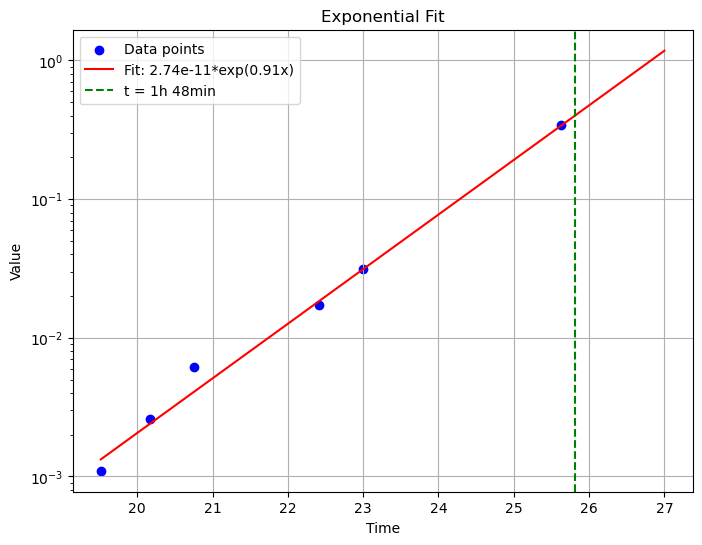

Fitted function: y = 2.74e-11 * exp(0.91 * x)


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define exponential function
def exp_func(x, a, b):
    return a * np.exp(b * x)

# Convert lists to numpy arrays
#t = np.array([19.5, 20.16, 20.75, 22.45])
#y = np.array([0.0011, 0.0026, 0.0062, 0.0175])

# Fit exponential function
popt, pcov = curve_fit(exp_func, t, y)
a, b = popt

# Generate points for smooth curve
t_smooth = np.linspace(min(t), 27, 100)
y_fit = exp_func(t_smooth, a, b)

# Find where y reaches 0.4
t_at_04 = np.log(0.4/a)/b

def hours_to_hm(hours):
    h = int(hours)
    m = int((hours - h) * 60)
    return f"{h}h {m}min"

# Add this line after finding t_at_04
time_hm = hours_to_hm(t_at_04 - 24)
print(f"Time to reach 0.4: {time_hm}")

# Create plot
plt.figure(figsize=(8, 6))
plt.scatter(t, y, color='blue', label='Data points')
plt.plot(t_smooth, y_fit, 'r-', label=f'Fit: {a:.2e}*exp({b:.2f}x)')

plt.axvline(x=t_at_04, color='green', linestyle='--', label=f't = {time_hm}')

plt.yscale('log')  

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Exponential Fit')
plt.legend()
plt.grid(True)
plt.show()

print(f"Fitted function: y = {a:.2e} * exp({b:.2f} * x)")